In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.fftpack

Aqui tive que fazer uma consideração em relação à forma de utilizar e variar o campo aleatório. A distribuição gaussiana do campo é dada por:

$$P(h_i) = \frac{1}{\sqrt{2\pi \Delta^2}}e^{-h_i^2/(2\Delta^2)}$$

Sendo assim, o termo `h` estava endo utilizado inapropriadamente para variar o campo. Na função do campo ``grf``troquei `h` por `r`, pois este termo remete à regularidade do campo e não confunde com o termo de campo da Hamiltoniana. Além disso, esta função retorna `gfield`que é a intensidade do campo. Se `r` for grande suficiente (ex. `r` = 10.), vemos que o campo tem uma forma regular, já se `r`for suficientemente pequeno (ex. `r`= 0.05) vemos que ele se comporta mais aleatoriamente. O termo $\Delta$ da equação regula a amplitude do campo, é esta variável que devemos manipular para obtermos as representações do campo.

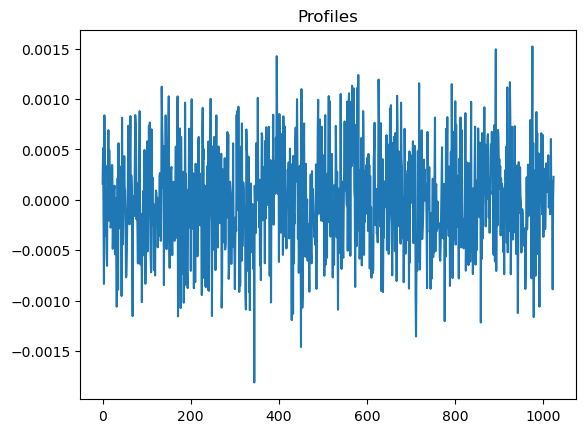

mean: 1.5246593050577406e-20
std: 0.0005


In [ ]:
r =0.05
size = 2**10
delta = 0.0005
flag_normalize = True

k_idx = np.mgrid[:size] - int( (size + 1)/2 )
k_idx = scipy.fftpack.fftshift(k_idx)

amplitude = np.power( k_idx**2 + 1e-10, -r/4.0 )
amplitude[0] = -1

noise = np.random.normal(size=(size)) \
     + 1j * np.random.normal(size=(size))

gfield = np.fft.ifft(noise * amplitude).real
# gfield = numpy.fft.ifft(amplitude).real

if flag_normalize:
    gfield = gfield - np.mean(gfield)
    gfield = delta*gfield/np.std(gfield)

plt.plot(gfield)
plt.title('Profiles')
plt.show()
print('mean:', np.mean(gfield))
print('std:', np.std(gfield))

In [ ]:
# Initial state
@jit(forceobj=True)
def inicial(N):
    state = 2*np.random.randint(2,size=N)-1
    return state

# Gaussian random field
@jit(forceobj=True)
def grf(N, delta, r = 0.05, flag_normalize = True):

    k_idx = np.mgrid[:N] - (N + 1)//2
    k_idx = scipy.fftpack.fftshift(k_idx)

    amplitude = np.power( k_idx**2 + 1e-10, - r/4.0 )
    amplitude[0] = 0

    noise = np.random.normal(size=(N)) \
        + 1j * np.random.normal(size=(N))

    gfield = np.fft.ifft(noise * amplitude).real

    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = delta*gfield/np.std(gfield)

    return gfield

# Spin flip
@jit(forceobj=True)
def spin_flip(N,beta,config,alpha,delta):
    rindex = np.random.randint(N, size=N)
    ji = np.arange(1,N)**alpha
    H = grf(N,delta)
    for a in rindex:
        s = config[a]
        jr = ji[:a]
        nb = (config[:a]/jr[::-1]).sum() + (config[a+1:]/ji[:N-a-1]).sum()
        cost = 2*s*(nb + H[a]) # cost = 2*E (E1 - E0 = 2E)
        if cost < 0:
            s *= -1
        elif np.random.rand() < np.exp(-cost*beta):
            s *= -1
        config[a] = s
    return config

# Energy
@jit(forceobj=True)
def energy(N, config,alpha,delta):
    e = 0
    H = grf(N,delta)
    H = H*config
    ji = np.arange(1,N)**alpha
    for i in range(N):
        e += (-config[i]*config[i+1:]/ji[:N-i-1] - H[i]).sum()
    return e

# Magnetization
@jit(forceobj=True)
def magnetization(N,config):
    m = config.sum()
    return m

In [ ]:
nt     = 100        #  number of temperature points
N      = 2**10       #  size of the lattice, N
alpha = np.array([1.0,1.4,1.8,2.2])        #  exponent of the long range interaction.
delta = 0.02            #  external field

eqSteps = 1000       #  number of MC sweeps for equilibration
mcSteps = 1000       #  number of MC sweeps for calculation

# valores de temperatura
T       = np.linspace(1, 15, nt);

#  arrays para armazenar os valores médios
E,M,C,X,Cr,Rho = np.zeros((len(alpha),nt)), np.zeros((len(alpha),nt)), np.zeros((len(alpha),nt)), np.zeros((len(alpha),nt)), np.zeros(nt), np.zeros(nt)


n1, n2  = 1.0/(mcSteps*N), 1.0/(mcSteps*mcSteps*N)

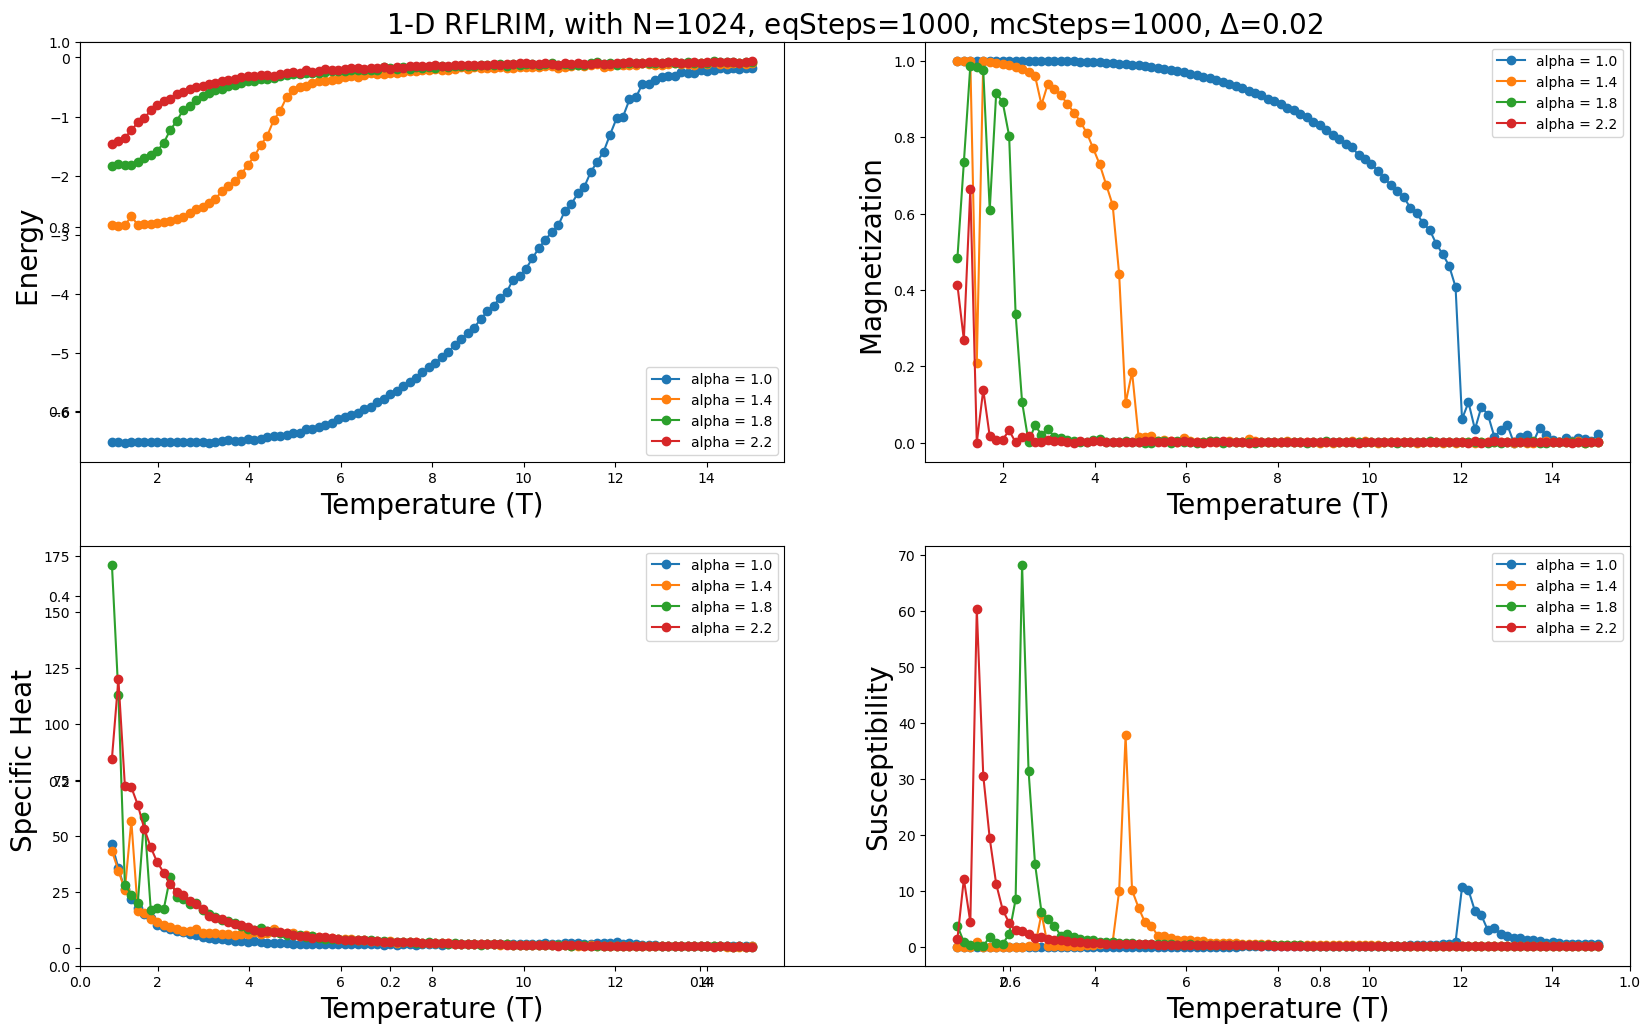

In [ ]:
# Funcoes variando com a temperatura
for j in range(len(alpha)):

    for tt in range(nt):
        E1 = M1 = E2 = M2 = 0
        config = inicial(N)
        iT=1/T[tt]; iT2=iT*iT; # Termos referentes à temperatura => beta = 1/kT, k=1 é a constante de Boltzmann

        for i in range(eqSteps):         # equilibrate
            spin_flip(N,iT,config,alpha[j],delta)         # Monte Carlo moves

        for i in range(mcSteps):
            spin_flip(N,iT,config,alpha[j],delta)
            Ene = energy(N,config,alpha[j],delta)     # calculate the energy
            Mag = magnetization(N,config)        # calculate the magnetisation

            E1 = E1 + Ene
            M1 = M1 + Mag
            M2 = M2 + Mag*Mag
            E2 = E2 + Ene*Ene

        E[j][tt] = E1*n1
        M[j][tt] = M1*n1
        C[j][tt] = (E2*n1 - E1*E1*n2)*iT2
        X[j][tt] = (M2*n1 - M1*M1*n2)*iT

f = plt.figure(figsize=(20, 12)); # plot the calculated values

plt.title(f'1-D RFLRIM, with N={N}, eqSteps={eqSteps}, mcSteps={mcSteps}, $\\Delta$={delta}', fontsize=20);

sp =  f.add_subplot(2, 2, 1 );
for j in range(len(alpha)):
    plt.plot(T, E[j],'-o', label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Energy ", fontsize=20);
    plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 2 );
for j in range(len(alpha)):
    plt.plot(T, abs(M)[j],'-o', label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Magnetization ", fontsize=20);
    plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 3 );
for j in range(len(alpha)):
    plt.plot(T, C[j], '-o',label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Specific Heat ", fontsize=20);
    plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 4 );
for j in range(len(alpha)):
    plt.plot(T, X[j], '-o',label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Susceptibility", fontsize=20);
    plt.legend(loc='best');

plt.savefig(f'Imagens/1d_rflrim_N{N}_mcS{mcSteps}_eq{eqSteps}_delta{delta}.png', bbox_inches='tight')


Na função do calor específico há uma consideração a ser feita. Quando $T \rightarrow 0$ há uma indeterminação e a função tente ao infinito. Mas quando $T \rightarrow T_c$, a função exibe o comportamento similar ao modelo sem campo. Abaixo segue um exemplo de comparação. Note que o gráfico inicia em $x =2$, e a temperatura crítica é proxima de 12.

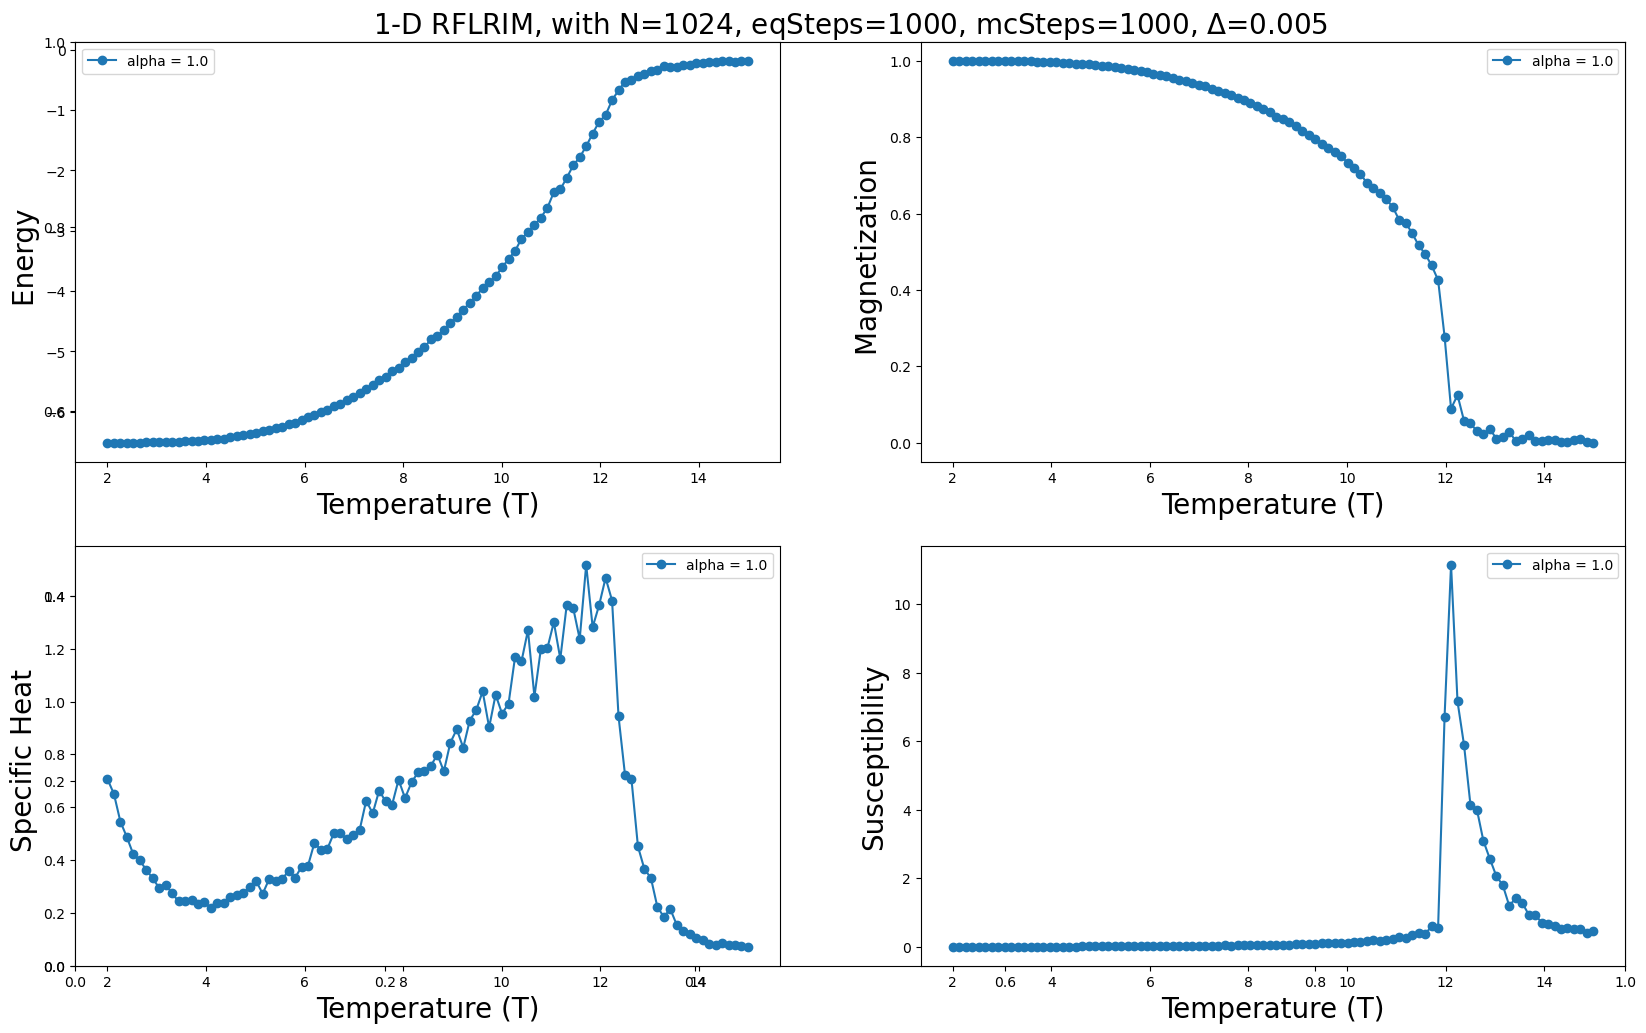